In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.transforms import transforms
from PIL import Image
import torchvision.transforms.functional as tvf
import torchvision.utils as tvu
from torch import Tensor
import torchvision.transforms as tvt
import os
from tqdm import tqdm
import random
import datasets
from positional_embeddings import PositionalEmbedding

## Utils

## Dataset
要将图像转为值在[-1,1]之间的Tensor

In [2]:
dataset = datasets.get_dataset('dino')
training_dataloader = DataLoader(dataset, batch_size=128, shuffle=True, drop_last=True)

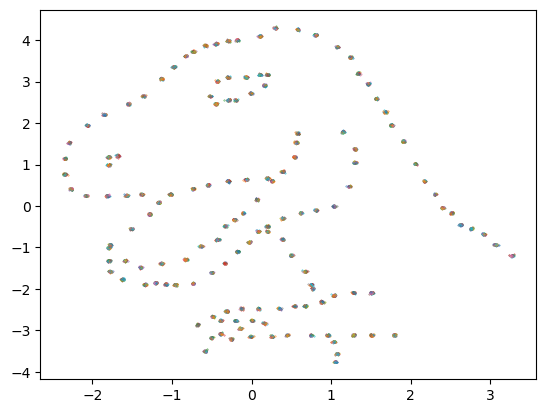

In [3]:
for batch in training_dataloader:
    plt.scatter(batch[0][:,0], batch[0][:,1], s=0.1)
plt.show()

### Set parameters and load data

总步数n_steps=1000，$\beta\in[10^{-4},0.02]$且为线性间隔取值

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

n_steps = 500
# 注意下标从0开始
beta = torch.linspace(0.0001, 0.02, n_steps).to(device)
alpha = 1 - beta
alpha_bar = torch.cumprod(alpha, dim=0)
sigma = torch.sqrt(beta)

In [5]:
print('beta[0:10]:', beta[0:10])
print('alpha[0:10]:', alpha[0:10])
print('alpha_bar[0:10]', alpha_bar[0:10])
print('sigma[0:10]', sigma[0:10])

beta[0:10]: tensor([1.0000e-04, 1.3988e-04, 1.7976e-04, 2.1964e-04, 2.5952e-04, 2.9940e-04,
        3.3928e-04, 3.7916e-04, 4.1904e-04, 4.5892e-04], device='cuda:0')
alpha[0:10]: tensor([0.9999, 0.9999, 0.9998, 0.9998, 0.9997, 0.9997, 0.9997, 0.9996, 0.9996,
        0.9995], device='cuda:0')
alpha_bar[0:10] tensor([0.9999, 0.9998, 0.9996, 0.9994, 0.9991, 0.9988, 0.9985, 0.9981, 0.9977,
        0.9972], device='cuda:0')
sigma[0:10] tensor([0.0100, 0.0118, 0.0134, 0.0148, 0.0161, 0.0173, 0.0184, 0.0195, 0.0205,
        0.0214], device='cuda:0')


### Get $x_t$
$$\boldsymbol{x_t}=\sqrt{\bar{\alpha}_t}\boldsymbol{x_0}+\sqrt{1-\bar{\alpha}_t}\boldsymbol{\epsilon}$$
$$\boldsymbol{\epsilon}\sim N(0,I)$$
对于`get_xt_given_x0_and_t`，每次使用的$\boldsymbol{\epsilon}$是一样的，应该从外部传入

In [6]:
def get_xt_given_x0_and_t(x0, t, eps):
    sqrt_alpha_bar_t = torch.sqrt(alpha_bar[t-1]).view(-1, 1)
    sqrt_one_minus_sqrt_alpha_bar_t = torch.sqrt(1-alpha_bar[t-1]).view(-1,1)
    
    mean = sqrt_alpha_bar_t * x0
    std = sqrt_one_minus_sqrt_alpha_bar_t
    xt = mean + std * eps
    return xt

In [7]:
def show_diffusion():
    diffusion = []
    
    for batch in training_dataloader:
        x0s = batch[0].to(device)
        for x0 in x0s:
            one_point_diffusion = []
            eps = torch.randn(1, 2).to(device)
            for t in range(1, n_steps+1, 50):
                xt = get_xt_given_x0_and_t(x0, t, eps)
                one_point_diffusion.append(xt)
            one_point_diffusion = torch.stack(one_point_diffusion)
            diffusion.append(one_point_diffusion)

    diffusion = torch.stack(diffusion).view(-1, 20, 2)
    diffusion = diffusion.cpu()

    plt.figure(figsize=(15,15))
    for t in range(1, n_steps//50+1):
        plt.subplot(5, 4, t)
        plt.scatter(diffusion[:, t-1, 0], diffusion[:, t-1, 1], s=0.1)
        plt.axis('off')
    plt.show()

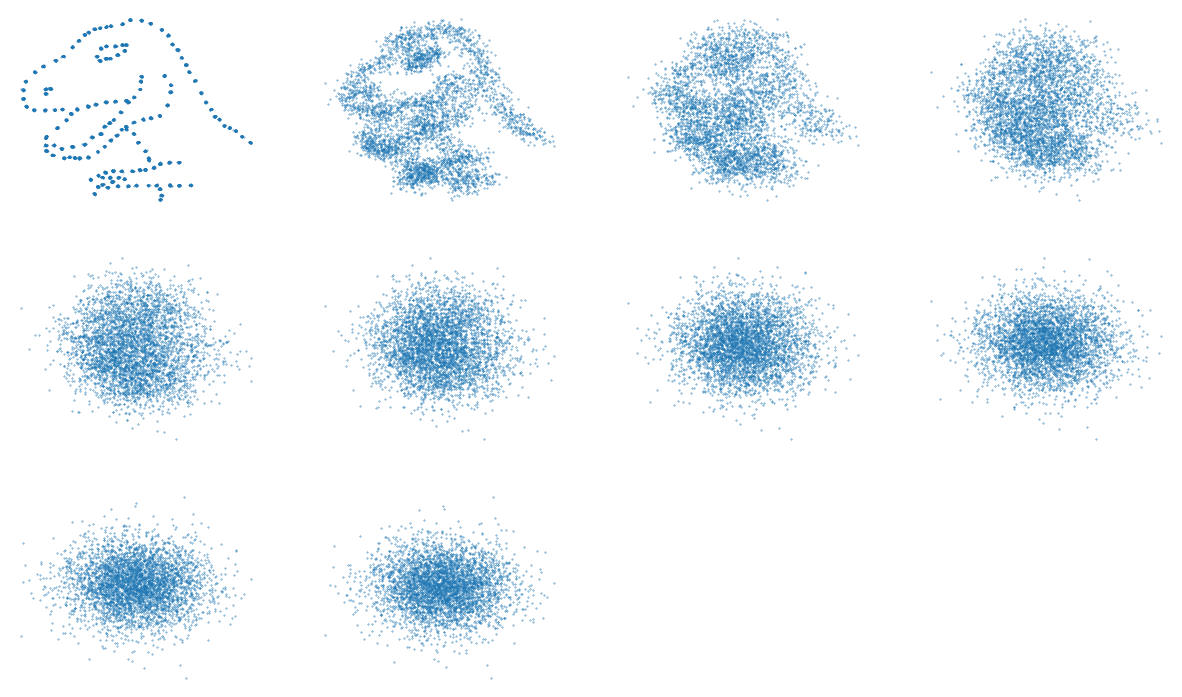

In [8]:
show_diffusion()

### Sampling with trained model
$$\boldsymbol{x}_{t-1}=\frac{1}{\sqrt{\alpha}}(\boldsymbol{x}_t-\frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}*\boldsymbol{\epsilon}_\theta(\boldsymbol{x}_t, t))+\sigma_t*\boldsymbol{z}$$
$$\boldsymbol{z}\sim N(0,I)$$

In [22]:
def sampling(xt, T, model, start, end, step):
    sampling_results = []
    # 计算x_{T-1},...,x0
    for i in range(T, 0, -1):
        z = torch.randn(*xt.shape).to(device)

        t = (torch.zeros((xt.shape[0],))+i).long().to(device)

        eps_theta = model(xt, t)

        assert not torch.any(torch.isnan(eps_theta)), 'in function `sampling`, eps_theta is nan!'

        coeff = 1. / torch.sqrt(alpha[i-1])
        coeff_eps_theta = (1-alpha[i-1]) / torch.sqrt(1 - alpha_bar[i-1])
        if i == 1:
            xt = coeff * (xt - coeff_eps_theta * eps_theta)
        else:
            xt = coeff * (xt - coeff_eps_theta * eps_theta) + sigma[i-1] * z

        # 存放结果，在[start, end]中每step取一个样本
        if i >= start and i <= end and (i-1) % step == 0 or i == end:
            sampling_results.append(xt)

    sampling_results = torch.stack(sampling_results)

    return sampling_results

## Model

In [10]:
class Block(nn.Module):
    def __init__(self, size: int):
        super().__init__()

        self.ff = nn.Linear(size, size)
        self.act = nn.GELU()

    def forward(self, x: torch.Tensor):
        return x + self.act(self.ff(x))


In [11]:
class MLP(nn.Module):
    def __init__(self, hidden_size: int = 128, hidden_layers: int = 3, emb_size: int = 128,
                 time_emb: str = "sinusoidal", input_emb: str = "sinusoidal"):
        super().__init__()

        self.time_mlp = PositionalEmbedding(emb_size, time_emb)
        self.input_mlp1 = PositionalEmbedding(emb_size, input_emb, scale=25.0)
        self.input_mlp2 = PositionalEmbedding(emb_size, input_emb, scale=25.0)

        concat_size = len(self.time_mlp.layer) + \
            len(self.input_mlp1.layer) + len(self.input_mlp2.layer)
        layers = [nn.Linear(concat_size, hidden_size), nn.GELU()]
        for _ in range(hidden_layers):
            layers.append(Block(hidden_size))
        layers.append(nn.Linear(hidden_size, 2))
        self.joint_mlp = nn.Sequential(*layers)

    def forward(self, x, t):
        x1_emb = self.input_mlp1(x[:, 0])
        x2_emb = self.input_mlp2(x[:, 1])
        t_emb = self.time_mlp(t)
        x = torch.cat((x1_emb, x2_emb, t_emb), dim=-1)
        x = self.joint_mlp(x)
        return x

In [12]:
class AverageLogger(object):
    def __init__(self):
        super().__init__()
        self.avg = 0
        self.cnt = 0
        self.sum = 0

    def update(self, x, n=1):
        self.sum += x
        self.cnt += n
        self.avg = self.sum / self.cnt

    def clear(self):
        self.avg = 0
        self.cnt = 0
        self.sum = 0

### Train the model
$$\nabla_{\theta}\Vert \boldsymbol{\epsilon}-\boldsymbol{\epsilon}_{\theta}(x_t, t)\Vert^2$$

In [13]:
model = MLP().to(device)

criterion = nn.MSELoss()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

epoch_num = 200

model.train() # 开启训练模式！
training_samples_size = len(training_dataloader) * 128 # len(training_dataloader)是training_dataloader的批次数目


for i in range(epoch_num):
    with tqdm(total=training_samples_size, ncols=100) as p_bar:
        # 设置进度条描述
        p_bar.set_description(f'Epoch: {i + 1}')
        for input_images in training_dataloader:
            x0 = batch[0].to(device)

            eps = torch.randn(x0.shape).to(device)

            t = torch.randint(1, n_steps, (x0.shape[0],)).long().to(device)

            xt = get_xt_given_x0_and_t(x0, t, eps)

            eps_theta = model(xt, t)

            # assert not torch.isnan(eps_theta).any(), "NaN values found in eps_theta"

            loss = criterion(eps_theta, eps)
            loss.backward()
            # 记录损失
            p_bar.set_postfix({'loss': loss.item()})
            
            # nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            # 打印梯度
            #for name, param in model.named_parameters():
                #if param.grad is not None:
                    #print(name, torch.max(param.grad))

            # nn.utils.clip_grad_norm_(model.parameters(), 2, norm_type=2) # 梯度裁剪

            optimizer.step()
            optimizer.zero_grad()
            
            # 更新进度条&显示损失及指标
            p_bar.update(x0.shape[0])

Epoch: 200: 100%|█████████████████████████████████| 7936/7936 [00:00<00:00, 25653.41it/s, loss=0.41]


## Sampling

In [35]:
model.eval() # 开启评估模式！
with torch.no_grad():
    noise = torch.randn(1000, 2).to(device)
    sampling_results = sampling(noise, n_steps, model, 1, n_steps, 50)

In [36]:
sampling_results = sampling_results.detach().cpu()

In [37]:
sampling_results.shape

torch.Size([11, 1000, 2])

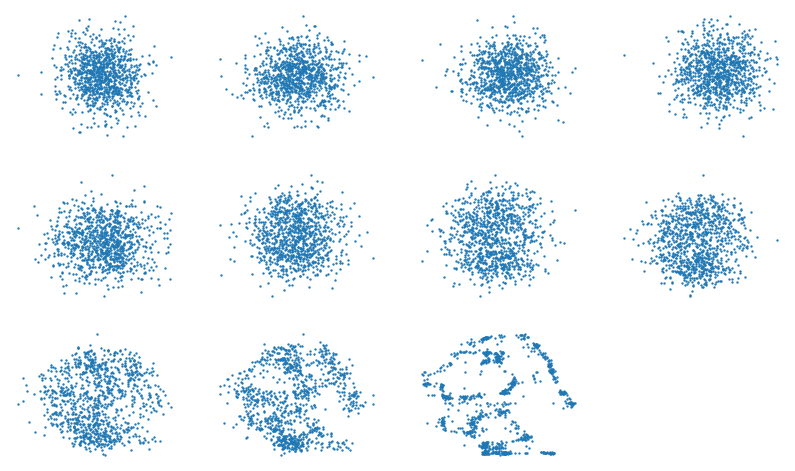

In [38]:
plt.figure(figsize=(10, 10))
num = sampling_results.shape[0]
for i in range(num):
    plt.subplot(5, 4, i+1)
    plt.scatter(sampling_results[i,:,0], sampling_results[i,:,1], s=0.5)
    plt.axis('off')
plt.show()